In [19]:
import os
import sys

# Get the current working directory (where your notebook is running)
script_dir = os.getcwd()

# Go one level up
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

# Insert the parent directory into Python path
sys.path.insert(0, parent_dir)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from env.pcm_storage import hp_system
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting
from sklearn.linear_model import LinearRegression

In [21]:
def solve_rpm_and_eer(Q_cool, dt, T_cond, hp):
    """
    Given:
      Q_cool (kWh)  : Total cooling provided in time dt
      dt (s)        : Duration of the interval in seconds
      T_cond (°C)   : Condenser temperature
      hp            : An object with attributes:
                      hp.Q_intercept, hp.a, hp.b, hp.c, hp.d,
                      hp.EER_intercept, hp.e, hp.f, hp.g, hp.h
    
    Returns:
      (e, EER)
      where e is the electrical energy (kWh) used over dt,
            EER is the dimensionless energy-efficiency ratio.
    """
    # 1) Compute Q_dot_cool (kW)
    Q_dot_cool = Q_cool * 3600.0 / dt  # kW

    # 2) Solve for rpm from the polynomial:
    #    c*rpm^2 + a*rpm + (Q_intercept + b*T_cond + d*T_cond^2 - Q_dot_cool) = 0
    A = hp.c
    B = hp.a
    C = (hp.Q_intercept 
         + hp.b * T_cond 
         + hp.d * (T_cond ** 2) 
         - Q_dot_cool)

    # Handle the case where A is nearly 0 (degenerate quadratic => linear)
    if abs(A) < 1e-12:
        if abs(B) < 1e-12:
            raise ValueError("Both c and a are ~0, cannot solve.")
        rpm_candidate = -C / B
        if rpm_candidate <= 0:
            raise ValueError("No positive RPM solution found in linear case.")
        rpm = rpm_candidate
    else:
        # Solve the quadratic equation for rpm
        disc = B**2 - 4*A*C
        if disc < 0:
            # If the discriminant is negative, then set rpm and EER to 0
            return 0, 0

        sqrt_disc = math.sqrt(disc)
        rpm1 = (-B + sqrt_disc) / (2*A)
        rpm2 = (-B - sqrt_disc) / (2*A)

        # Filter for physically valid (positive) solutions
        candidates = [r for r in (rpm1, rpm2) if r > 0]
        if not candidates:
            raise ValueError("No positive RPM solution found.")
        rpm = candidates[0]
    
    # 3) Compute EER with the solved rpm
    EER = (hp.EER_intercept
           + hp.e * rpm
           + hp.f * T_cond
           + hp.g * (rpm ** 2)
           + hp.h * (T_cond ** 2))
    
    # If EER is zero, avoid division by zero; otherwise compute e.
    if EER == 0:
        e = 0
    else:
        e = Q_cool / EER

    return e, EER

In [22]:
def add_e_and_eer_columns(df, hp, load_col='load', T_cond_col='T_cond', rpm_col='rpm'):
    """
    Given a DataFrame with columns for load (Q_cool in kWh), T_cond (condenser temperature in °C),
    and rpm (operating rpm), compute the EER and electrical energy consumption e for each row.
    
    The EER is computed via:
    
        EER = hp.EER_intercept + hp.e * rpm + hp.f * T_cond + hp.g * rpm**2 + hp.h * T_cond**2
        
    and the electrical energy is:
    
        e = Q_cool / EER   (with a safeguard if EER is zero)
    
    Parameters:
      df        : Pandas DataFrame containing the required columns.
      hp        : An object with attributes:
                     hp.EER_intercept, hp.e, hp.f, hp.g, hp.h.
      load_col  : Name of the column with Q_cool (in kWh). Default is 'load'.
      T_cond_col: Name of the column with T_cond (°C). Default is 'T_cond'.
      rpm_col   : Name of the column with rpm. Default is 'rpm'.
    
    Returns:
      The DataFrame with two new columns: 'e' and 'EER'.
    """
    def compute_row_values(row):
        # Extract the required values from the row
        rpm = row[rpm_col]
        T_cond = row[T_cond_col]
        Q_cool = row[load_col]  # Q_cool in kWh
        
        # Compute EER using the polynomial correlation
        EER = (hp.EER_intercept +
               hp.e * rpm +
               hp.f * T_cond +
               hp.g * (rpm ** 2) +
               hp.h * (T_cond ** 2))
        
        # Avoid division by zero: if EER is zero, set e to zero.
        e = Q_cool / EER if EER != 0 else 0
        
        return pd.Series({'e': e, 'EER': EER})
    
    # Apply the row-wise computation and assign new columns
    df[['e', 'EER']] = df.apply(compute_row_values, axis=1, result_type='expand')

    return df

Benchmark_1H

In [23]:
total_df = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df.pkl'))
hp_15T = hp_system(dt=900)   # Initialize the HP system
baseline_15T = pd.DataFrame()

dt = 900

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_15T[['e', 'EER']] = total_df.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_15T),
    axis=1,
    result_type='expand'
)

baseline_15T.to_pickle('./baseline_15T.pkl')

In [24]:
total_df_hourly = pd.read_pickle(os.path.join(parent_dir, 'data', 'total_df_hourly.pkl'))
hp_1H = hp_system(dt=3600)   # Initialize the HP system
baseline_1H = pd.DataFrame()

dt = 3600

# Use DataFrame.apply with a lambda that calls solve_rpm_and_eer
baseline_1H[['e', 'EER']] = total_df_hourly.apply(
    lambda row: solve_rpm_and_eer(row['load'], dt, row['outdoor_temp'], hp_1H),
    axis=1,
    result_type='expand'
)

baseline_1H.to_pickle('./baseline_1H.pkl')

Results analysis

In [25]:
df_results_1H = pd.read_pickle('./results_1H.pkl')
df_results_15T = pd.read_pickle('./results_15T.pkl')

In [26]:
# Calculate electricity consumption (e) and EER
#df_results_15T = add_e_and_eer_columns(df_results_15T, hp_15T, load_col='load', T_cond_col='outdoor_temp', rpm_col='rpm')
#df_results_1H = add_e_and_eer_columns(df_results_1H, hp_1H, load_col='load', T_cond_col='outdoor_temp', rpm_col='rpm')

In [31]:
date_index = pd.date_range(start='2021-07-01 00:00:00', periods=len(df_results_15T), freq='15min')
df_results_15T.index = date_index
df_results_15T['EER'] = df_results_15T['Q_cool'] * df_results_15T['EER'] / (df_results_15T['Q_cool']+1e-3)
df_results_15T['e_hp'] = df_results_15T['Q_cool'] * df_results_15T['e_hp'] / (df_results_15T['Q_cool']+1e-3)

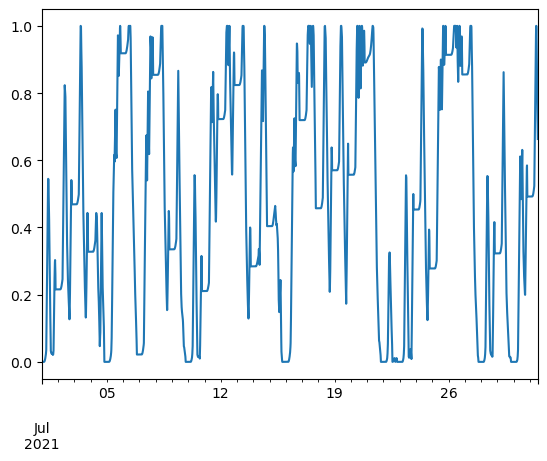

In [32]:
df_results_15T['soc'].plot()
baseline_15T.index = pd.date_range(start='2021-01-01 00:00:00', periods=len(baseline_15T), freq='15min')

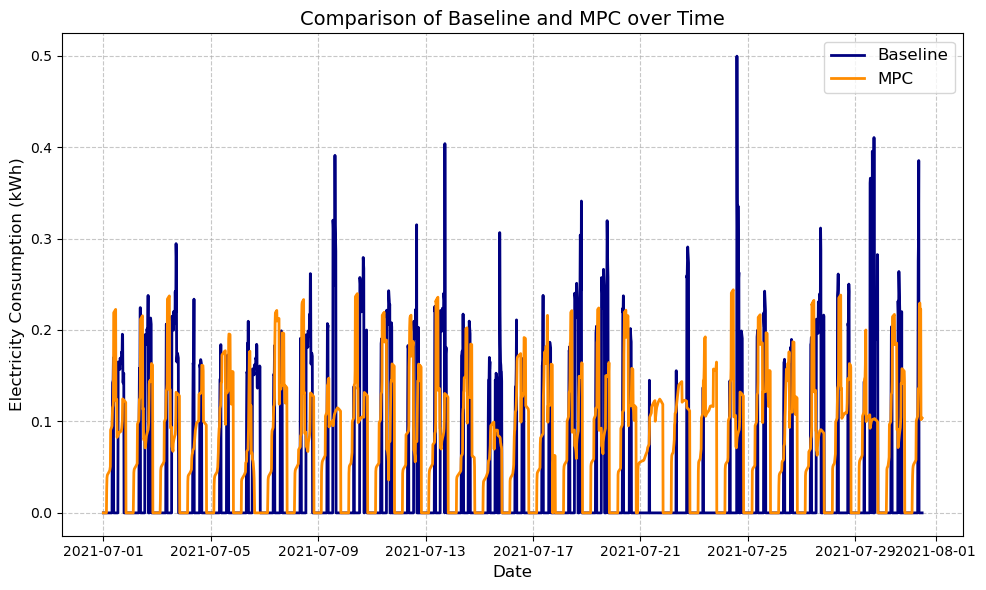

In [36]:
# Extract relevant data
baseline_15T_val = baseline_15T.loc[date_index, 'e']
rl_mpc_val = df_results_15T['e_hp']

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the baseline
plt.plot(baseline_15T_val, label='Baseline', color='navy', linewidth=2)

# Plot the RL-MPC
plt.plot(rl_mpc_val, label='MPC', color='darkorange', linewidth=2)

# Add a title and labels
plt.title('Comparison of Baseline and MPC over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)

# Show legend
plt.legend(loc='best', fontsize=12)

# Add grid lines for readability
plt.grid(True, linestyle='--', alpha=0.7)

# (Optional) Adjust the x-axis to show dates more clearly
# plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
